# Code metrics analysis

This notebooks demonstrates how to use __[codemetrics](https://github.com/elmotec/codemetrics)__ to gain insight on a code base.

In [1]:
import os
import pathlib as pl
import datetime as dt
import textwrap
import json
import pathlib as pth
import logging
import sys

import joblib
import pandas as pd
import numpy as np
import altair as alt
from altair.vega.v5 import Vega
from tqdm import tqdm

import codemetrics as cm
import codemetrics.vega

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload

In [3]:
log = cm.log
logging.basicConfig(format="%(relativeCreated)6d %(level)s %(message)s")
log.setLevel(logging.WARNING) 
log.info("logging enabled")

## Setup

Sets up a few useful things:
    - define a few useful variables like `year_ago` 
    - change directory to the location of the project being analyzed.
    - joblib.Memory to cache some outputs and clearing out the cache when we execute this cell.


In [15]:
# Useful variables
year_ago = dt.datetime.now(tz=dt.timezone.utc) - dt.timedelta(365)

# Change current directory to the project under being analyzed.
pandas = cm.GitProject(pl.Path().absolute() / '..' / '..'/  'pandas')

# Sets up caching and wipes out cache if any.
disk = joblib.Memory(location=os.getenv('TEMP'), verbose=0)
get_cloc = disk.cache(cm.get_cloc)
get_cloc.clear()

## Lines of code (loc)

Leverage cloc to count the lines of code and infer some basic information about the languages used in this project.

In [16]:
cloc_program = 'cloc.exe'
loc = cm.get_cloc(cwd=target_location, cloc_program=cloc_program)

In [17]:
loc.head(3)

,language,path,blank,comment,code
0,SVG,doc/source/_static/schemas/04_plot_overview.svg,1,1,6441
1,HTML,pandas/tests/io/data/html/banklist.html,33,21,4832
2,Python,pandas/core/generic.py,1773,6126,3866


In [18]:
loc_sum = loc.groupby('language').sum().reset_index().melt(id_vars=['language']).rename(columns={'variable': 'type', 'value': 'lines'})
alt.Chart(loc_sum).mark_bar().encode(
    x=alt.X('lines:Q'),
    y=alt.Y('language:N', sort=alt.EncodingSortField(field='lines', op='sum', order='descending')),
    color=alt.Color('type:N', scale=alt.Scale(scheme='accent')), 
    tooltip=['lines:Q', 'type:O'],
).properties(title='Lines of code')

alt.Chart(...)

## Retrieve git log data

Now that we know what the code base looks like today, we turn our attention to history and build a data frame of the git log history for the past year. 

We then calculate the age of each file and generate a graph of recent changes as well as a circle visualization of the code base. 

In [19]:
log = pandas.get_log(path='.', after=year_ago)
log['issue'] = log['message'].str.extract(r'\(#(\d+)\)')
log = pd.merge(log, loc[['path']], left_on='path', right_on='path')

In [20]:
log.head(2)

,revision,author,date,path,message,kind,action,textmods,propmods,copyfromrev,copyfrompath,added,removed,issue
0,c5b4272ed,patrick,2021-01-16 14:21:17+00:00,doc/source/whatsnew/v1.2.1.rst,BUG: assert_frame_equal raising TypeError wit...,f,NaN,True,False,<NA>,<NA>,2.0,1.0,39204
1,a3b5c4901,jbrockmendel,2021-01-16 01:18:11+00:00,doc/source/whatsnew/v1.2.1.rst,REGR: NaT.__richmp__(dateobj) (#39196),f,NaN,True,False,<NA>,<NA>,1.0,1.0,39196


In [21]:
ages = cm.get_ages(log).merge(loc)
ages['last_change'] = ages['age'].apply(lambda a: pd.to_datetime('today') - dt.timedelta(a))
ages['age_in_week'] = ages['age'].apply(lambda d: int(d / 7))

width = 1000
weeks = list(range(int(400 / 7)))
chart = alt.Chart(ages).encode(color='language')
top = chart.mark_bar().\
    encode(x=alt.X('age_agg:O', sort='ascending', title='age in weeks', scale=alt.Scale(domain=weeks)),
           y=alt.Y('count(path):Q', title='Number of files'),
           color=alt.Color('language', scale=alt.Scale(scheme='tableau10')),
           tooltip=['count(path)', 'language']
          ).\
    transform_calculate(age_agg='floor(datum.age / 7)').\
    properties(width=width)
bottom = chart.mark_tick(size=60, thickness=2, opacity=.3).\
    encode(x=alt.X('age:Q', title='age in days'),
           tooltip='path').properties(width=width)
alt.vconcat(top, bottom)

alt.VConcatChart(...)

c:\users\jlecomte\documents\github\codemetrics\codemetrics\vega.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["days"] = df["age"].astype("int32")


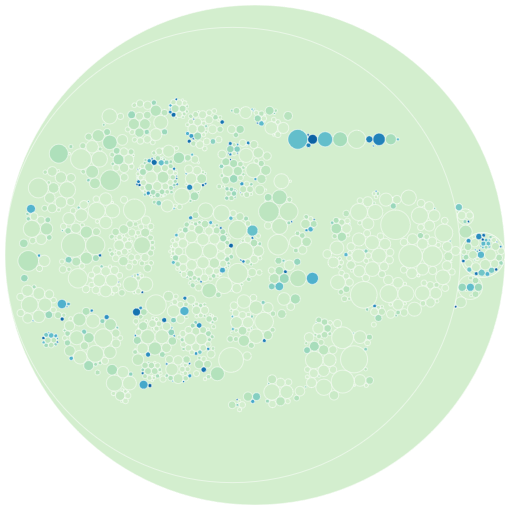

In [22]:
code_ages = ages.query("path.str.endswith('.py') | path.str.endswith('.c')")
desc = cm.vega.vis_ages(code_ages, height=500, width=500)
Vega(desc)

## Complexity

On to complexity calculation. Here we calculate the complexity of the current code base, file by file,
function by function so it could take a little long. We run it on .py files only and we leverage tqdm to
show a progress bar.

In [24]:
# Get Python file with the most recent revision
python_df = (log[['path', 'date']]
             .groupby('path', as_index=False)
             .max()
             .query("path.str.endswith('.py')")
             .merge(log[['path', 'date', 'revision']])
             .assign(path=lambda x: x["path"].astype("string"))
            )
# Progress bar for pandas
tqdm.pandas(desc="calculating")
# Calculates complexity on python files.
complexity = (python_df[['revision', 'path']]
              .groupby(['revision', 'path'])
              .progress_apply(cm.get_complexity, project=pandas)
             )


calculating: 100%|█████████████████████████████████████████████████████████████████| 1099/1099 [00:41<00:00, 26.49it/s]


In [25]:
# Calculates 80% percentile of complexity for each file
path_complexity = (complexity
                   .reset_index()[['path', 'cyclomatic_complexity', 'token_count']]
                   .groupby('path').quantile(0.8)
                   .sort_values(by='cyclomatic_complexity', ascending=False)
                   .reset_index()
                   .rename(columns={'cyclomatic_complexity': 'complexity'})
                  )
# Merge to lines of code. 
loc_cc = pd.merge(loc, path_complexity)

# Hot spots

Hot spots are files that exhibit high complexity __and__ changed a lot recently. This is typically where you will find bugs.

The graph below will show files harboring complexity as large circle while an increased number of change will make the color trend from yellow to more red shades.

In [26]:
hspots = cm.get_hot_spots(log.head(1), loc_cc.head(1))

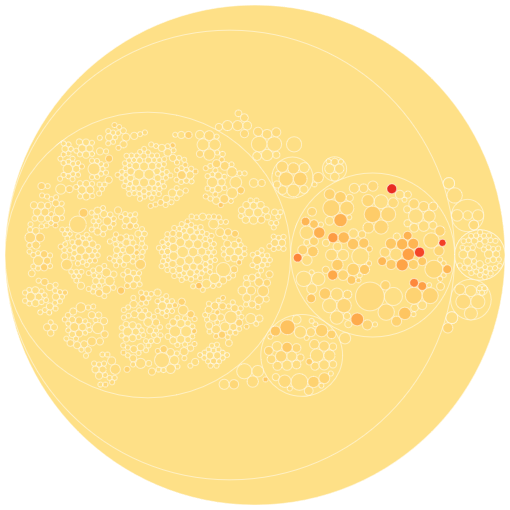

In [27]:
hspots = cm.get_hot_spots(log, loc_cc.assign(path=lambda x: x['path'].astype('string'))) 
hspots.query("language == 'Python'").sort_values(by=['changes', 'complexity'], ascending=False).head()
desc = cm.vega.vis_hot_spots(hspots, width=500, height=500, size_column='complexity')
Vega(desc)

## Co-changes or inter-file coupling

Co-changes builds on the idea that files or functions that change together imply a hidden dependency and may need refactoring.

We calculate how often each file change in relation to the other and display high level of coupling. Again, we focus on the files that have changed a lot recently.

In [28]:
co_changes = cm.get_co_changes(log, by='path', on='issue').\
    query("(coupling > .6) & (changes > 20)").\
    sort_values(by=['changes', 'cochanges'], ascending=False)
co_changes

,path,dependency,changes,cochanges,coupling
37423,pandas/core/indexes/numeric.py,pandas/core/indexes/base.py,57,40,0.701754
116417,pandas/tseries/offsets.py,pandas/_libs/tslibs/offsets.pyx,40,26,0.650000
24928,pandas/core/arrays/boolean.py,pandas/core/arrays/integer.py,34,21,0.617647
44067,pandas/core/window/ewm.py,pandas/core/window/rolling.py,28,20,0.714286


## File level analysis

It can also be useful to dive into the complexity history of one particular file or function. Let's consider the following file and calculate historical complexity of each function in the file. 

In [29]:
path = 'pandas/core/frame.py'
func_df = log[log['path'] == path][['date', 'revision', 'path']]
func_df.head()

,date,revision,path
881,2021-01-16 11:15:51+00:00,f51547cb7,pandas/core/frame.py
882,2021-01-15 16:30:22+00:00,963cf2b5a,pandas/core/frame.py
883,2021-01-13 13:23:13+00:00,4e93eb65f,pandas/core/frame.py
884,2021-01-11 17:07:00+00:00,46cec9f88,pandas/core/frame.py
885,2021-01-11 14:27:03+00:00,ec4a64464,pandas/core/frame.py


In [31]:
func_cplx_df = func_df.groupby(['revision', 'path']).progress_apply(cm.get_complexity, project=pandas)

calculating: 100%|███████████████████████████████████████████████████████████████████| 289/289 [00:30<00:00,  9.47it/s]


In [32]:
func_cpx_df = pd.merge(func_df, func_cplx_df.reset_index(), on=['revision', 'path'])
top_cpx_func_df = func_cpx_df.groupby('name')[['cyclomatic_complexity']].mean().nlargest(8, 'cyclomatic_complexity')
filt_func_cpx_df = func_cpx_df[func_cpx_df['name'].isin(set(top_cpx_func_df.index))]
filt_func_cpx_df.head()

,date,revision,path,function,cyclomatic_complexity,nloc,token_count,name,long_name,start_line,end_line,top_nesting_level,length,fan_in,fan_out,general_fan_out,file_tokens,file_nloc
10,2021-01-16 11:15:51+00:00,f51547cb7,pandas/core/frame.py,10,12,34,175,_repr_fits_horizontal_,"_repr_fits_horizontal_( self , ignore_width : ...",732,783,1,52,0,0,0,21088,7472
30,2021-01-16 11:15:51+00:00,f51547cb7,pandas/core/frame.py,30,25,75,450,to_dict,"to_dict( self , orient : str = ""dict"" , into =...",1474,1645,1,172,0,0,0,21088,7472
47,2021-01-16 11:15:51+00:00,f51547cb7,pandas/core/frame.py,47,18,37,314,__getitem__,"__getitem__( self , key )",3022,3082,1,61,0,0,0,21088,7472
66,2021-01-16 11:15:51+00:00,f51547cb7,pandas/core/frame.py,66,16,125,266,select_dtypes,"select_dtypes( self , include = None , exclude...",3676,3815,1,140,0,0,0,21088,7472
69,2021-01-16 11:15:51+00:00,f51547cb7,pandas/core/frame.py,69,11,25,202,_sanitize_column,"_sanitize_column( self , value )",3932,3980,1,49,0,0,0,21088,7472


In [33]:
alt.Chart(filt_func_cpx_df).\
    mark_line().encode(
        x='date:T',
        y='cyclomatic_complexity:Q',
        color='name:N',
        tooltip=['name', 'revision']
    )

alt.Chart(...)

To be continued...

In [53]:
filt_func_cpx_df.query("name == '_sanitize_column' and cyclomatic_complexity <= 11").sort_values(by="date").head(3)

,date,revision,path,function,cyclomatic_complexity,nloc,token_count,name,long_name,start_line,end_line,top_nesting_level,length,fan_in,fan_out,general_fan_out,file_tokens,file_nloc
3171,2020-12-14 17:59:45+00:00,35cc56586,pandas/core/frame.py,64,11,25,202,_sanitize_column,"_sanitize_column( self , value )",3898,3946,1,49,0,0,0,20654,7283
3011,2020-12-16 00:55:17+00:00,8455f5753,pandas/core/frame.py,64,11,25,202,_sanitize_column,"_sanitize_column( self , value )",3900,3948,1,49,0,0,0,20717,7291
2851,2020-12-17 13:46:45+00:00,d08f12c04,pandas/core/frame.py,64,11,25,202,_sanitize_column,"_sanitize_column( self , value )",3900,3948,1,49,0,0,0,20725,7292
